## Описание проекта

Задача — провести анализ и подготовить план действий по удержанию клиентов на основе клиентских данных сети фитнес-центров.

## Шаг 1. Загрузите данные

Данные содержат информацию на месяц до оттока и факт оттока на определённый месяц. 
Набор данных включает следующие поля:
- 'Churn' — факт оттока в текущем месяце;

Текущие поля в датасете:
Данные клиента за предыдущий до проверки факта оттока месяц:
- 'gender' — пол;
- 'Near_Location' — проживание или работа в районе, где находится фитнес-центр;
- 'Partner' — сотрудник компании-партнёра клуба (сотрудничество с компаниями, чьи сотрудники могут получать скидки на абонемент — в таком случае фитнес-центр хранит информацию о работодателе клиента);
- Promo_friends — факт первоначальной записи в рамках акции «приведи друга» (использовал промо-код от знакомого при оплате первого абонемента);
- 'Phone' — наличие контактного телефона;
- 'Age' — возраст;
- 'Lifetime' — время с момента первого обращения в фитнес-центр (в месяцах).

Информация на основе журнала посещений, покупок и информация о текущем статусе абонемента клиента:
- 'Contract_period' — длительность текущего действующего абонемента (месяц, 3 месяца, 6 месяцев, год);
- 'Month_to_end_contract' — срок до окончания текущего действующего абонемента (в месяцах);
- 'Group_visits' — факт посещения групповых занятий;
- 'Avg_class_frequency_total' — средняя частота посещений в неделю за все время с начала действия абонемента;
- 'Avg_class_frequency_current_month' — средняя частота посещений в неделю за предыдущий месяц;
- 'Avg_additional_charges_total' — суммарная выручка от других услуг фитнес-центра: кафе, спорт-товары, косметический и массажный салон.

«Культурист-датасаентист» предоставил сведения в csv-файлах. Заказчик подготовил данные, которые содержат данные на месяц до оттока и факт оттока на определённый месяц. 

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, silhouette_score

In [2]:
pip install -U seaborn

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 292 kB 2.4 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [2]:
pd.options.display.float_format = '{:.2f}'.format

In [3]:
try: 
    df = pd.read_csv('gym_churn.csv') 
except FileNotFoundError:
    df = pd.read_csv('/datasets/gym_churn.csv') # яндексовский путь

In [4]:
df.info() # вывод общей информации
df.sample(10, random_state=1) # вывод 5 рандомных строк

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
gender                               4000 non-null int64
Near_Location                        4000 non-null int64
Partner                              4000 non-null int64
Promo_friends                        4000 non-null int64
Phone                                4000 non-null int64
Contract_period                      4000 non-null int64
Group_visits                         4000 non-null int64
Age                                  4000 non-null int64
Avg_additional_charges_total         4000 non-null float64
Month_to_end_contract                4000 non-null float64
Lifetime                             4000 non-null int64
Avg_class_frequency_total            4000 non-null float64
Avg_class_frequency_current_month    4000 non-null float64
Churn                                4000 non-null int64
dtypes: float64(4), int64(10)
memory usage: 437.6 KB


,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
200,0,1,1,0,1,1,0,34,46.49,1.00,0,1.01,0.00,1
1078,1,1,0,0,1,1,0,27,24.55,1.00,4,1.39,0.98,1
610,1,1,1,1,1,6,1,31,85.67,6.00,1,1.01,0.73,1
2159,1,0,1,0,1,1,0,26,75.80,1.00,1,1.46,1.54,1
1169,0,0,0,0,1,1,0,31,410.76,1.00,3,2.40,2.47,0
2448,0,0,0,0,1,12,1,28,106.11,10.00,3,2.56,2.52,0
2938,1,1,0,0,0,1,0,23,199.16,1.00,0,2.95,2.70,1
813,1,1,1,1,1,6,1,34,115.87,4.00,9,0.65,0.57,0
1268,0,1,0,1,1,1,0,29,158.98,1.00,2,1.78,0.71,1
870,0,1,0,0,1,1,1,32,67.59,1.00,4,1.22,1.33,0


In [5]:
df.columns=df.columns.str.lower()

In [6]:
df['month_to_end_contract'].unique()

array([ 5., 12.,  1.,  6.,  3., 10., 11.,  9.,  4.,  7.,  8.,  2.])

In [7]:
df['month_to_end_contract'] = df['month_to_end_contract'].astype('int')

In [8]:
print('duplicates:', df.duplicated().sum()) # вывод количества дубликатов

duplicates: 0


Мы ознакомились с данными. Типы данных корректны, однако в переменной "срок до окончания текущего действующего абонемента (в месяцах)" мы заменили тип данных на целочисленный. Для удобства работы преобразовали названия столбцов (все названия теперь написаны строчными буквами). Пропусков и дубликатов не было обнаружено.

В нашем датасете информация о 4000 пользователей и 14 признаках по каждому.

## Шаг 2. Проведите исследовательский анализ данных (EDA)

#### Посмотрите на датасет: есть ли в нем отсутствующие признаки, изучите средние значения и стандартные отклонения (пригодится метод describe())

In [9]:
# посмотрим, как соотносятся классы набора данных
print('Соотношение классов:\n', df['churn'].value_counts())

Соотношение классов:
 0    2939
1    1061
Name: churn, dtype: int64


Сразу заметим, что классы по оттоку неравны - тех, кто остался в три раза больше чем тех, кто ушел.

In [10]:
df.describe()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
count,4000.00,4000.00,4000.00,4000.00,4000.00,4000.00,4000.00,4000.00,4000.00,4000.00,4000.00,4000.00,4000.00,4000.00
mean,0.51,0.85,0.49,0.31,0.90,4.68,0.41,29.18,146.94,4.32,3.72,1.88,1.77,0.27
std,0.50,0.36,0.50,0.46,0.30,4.55,0.49,3.26,96.36,4.19,3.75,0.97,1.05,0.44
min,0.00,0.00,0.00,0.00,0.00,1.00,0.00,18.00,0.15,1.00,0.00,0.00,0.00,0.00
25%,0.00,1.00,0.00,0.00,1.00,1.00,0.00,27.00,68.87,1.00,1.00,1.18,0.96,0.00
50%,1.00,1.00,0.00,0.00,1.00,1.00,0.00,29.00,136.22,1.00,3.00,1.83,1.72,0.00
75%,1.00,1.00,1.00,1.00,1.00,6.00,1.00,31.00,210.95,6.00,5.00,2.54,2.51,1.00
max,1.00,1.00,1.00,1.00,1.00,12.00,1.00,41.00,552.59,12.00,31.00,6.02,6.15,1.00


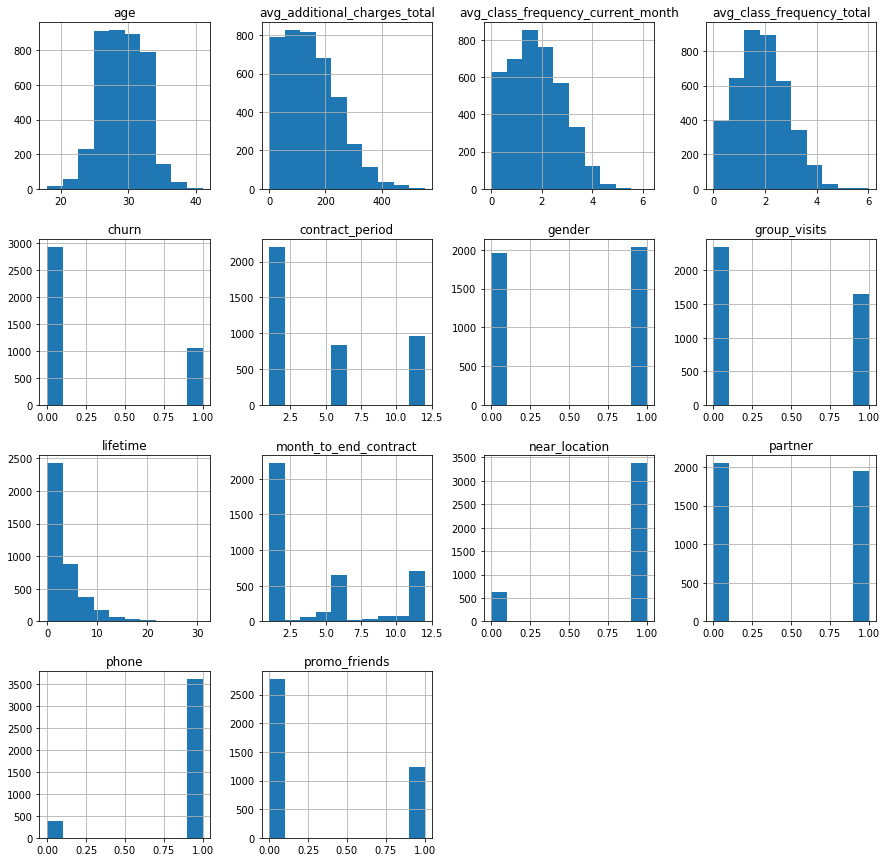

In [11]:
df.hist(figsize = (15,15)); 

У нас примерно поровну клиентов обоих полов, им от 18 до 41, средний возраст 29 лет, три четверти живут или работают рядом с фитнесом. Половина являются сотрудниками компании-партнёра, треть пришли в рамках акции «приведи друга».  Медианное время с момента первого обращения в фитнес-центр - 3 месяца (среднее - 3.72), три четверти всех клиентов записаны в фитнесс не более 5 месяцев назад. 90% всех клиентов оставили телефон для связи.

Чуть более половины всех абонементов - на 1 месяц, четверть на 6 месяцев, и еще четверть - на год. 40% клиентов посетили групповые занятия, средняя частота посещений в неделю за все время с начала действия абонемента - 1.88, а за предыдущий месяц 1.77. У половины все записанных действующий абонемент истекает через 1 месяц (т.е. в следующем месяце), а среднее количество месяцев оставшихся до конца абонемента - 4.32 месяца.

Средняя суммарная выручка от других услуг фитнес-центра: 147 рублей.

Мы не обнаружили отсутствующие признаки, также нельзя сказать, что есть существенные выбросы.

#### Посмотрите на средние значения признаков в двух группах — тех, кто ушел в отток и тех, кто остался (воспользуйтесь методом groupby())

In [12]:
df_grouped_churn = df.groupby('churn')[df.drop('churn', axis = 1).columns].agg(['mean']) 

In [13]:
with pd.option_context('display.precision', 3):
    df_grouped_churn=df_grouped_churn.style.background_gradient(cmap = 'Blues')
df_grouped_churn

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month
,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean
churn,,,,,,,,,,,,,
0,0.51,0.873,0.534,0.354,0.904,5.75,0.464,30,158,5.28,4.71,2.02,2.03
1,0.511,0.768,0.355,0.184,0.903,1.73,0.269,27,115,1.66,0.991,1.47,1.04


#### Постройте столбчатые гистограммы и распределения признаков для тех, кто ушёл (отток) и тех, кто остался (не попали в отток)

In [14]:
# для удобства, создадим словарь с названиями переменных
titles={   
'gender':'пол',
'near_location' :'проживание или работа в районе, где находится фитнес-центр',
'partner' : 'сотрудник компании-партнёра',
'promo_friends' : 'факт первоначальной записи в рамках акции «приведи друга»',
'phone' : 'наличие контактного телефона',
'age' : ' возраст',
'lifetime' : 'время с момента первого обращения в фитнес-центр (в месяцах)',
'contract_period' : ' длительность текущего действующего абонемента (месяц, 3 месяца, 6 месяцев, год)',
'month_to_end_contract' : 'срок до окончания текущего действующего абонемента (в месяцах)',
'group_visits' : ' факт посещения групповых занятий',
'avg_class_frequency_total' : ' средняя частота посещений в неделю за все время с начала действия абонемента',
'avg_class_frequency_current_month' : ' средняя частота посещений в неделю за предыдущий месяц',
'avg_additional_charges_total': 'суммарная выручка от других услуг фитнес-центра: кафе, спорт-товары, косметический и массажный салон',
'churn': 'факт оттока в текущем месяце',  
}

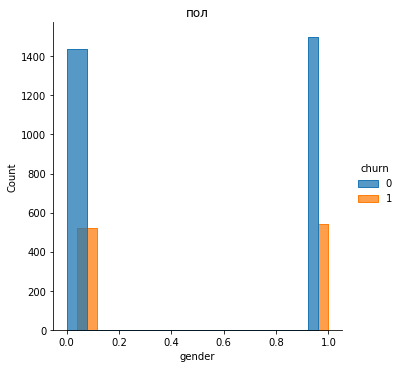

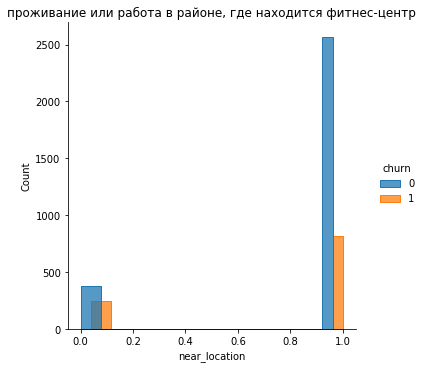

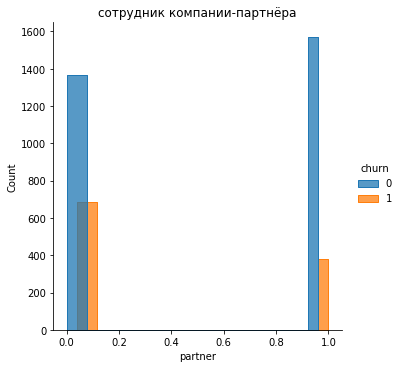

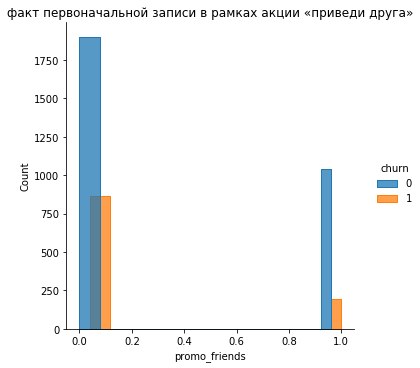

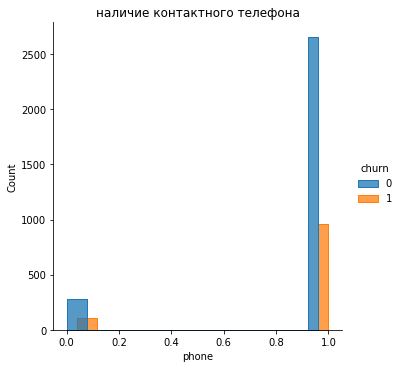

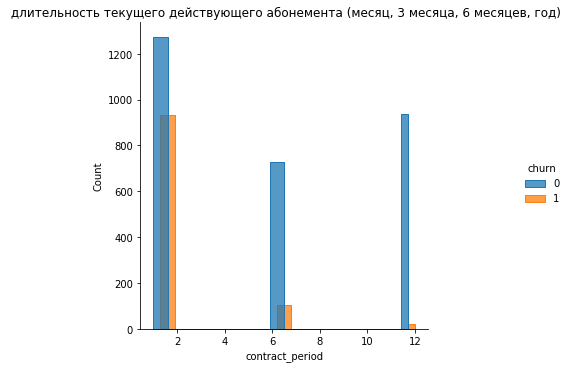

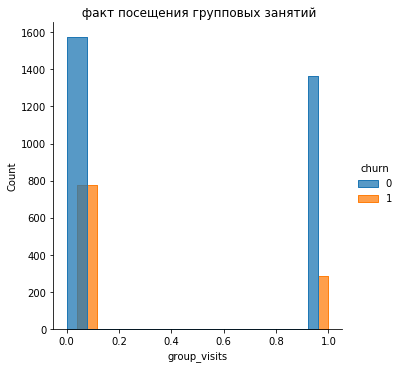

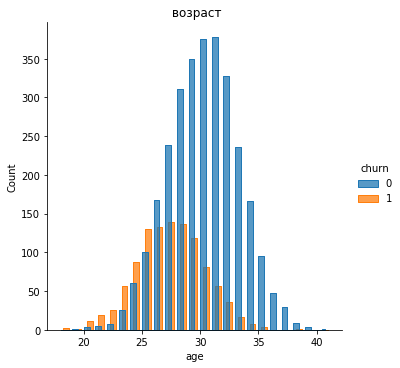

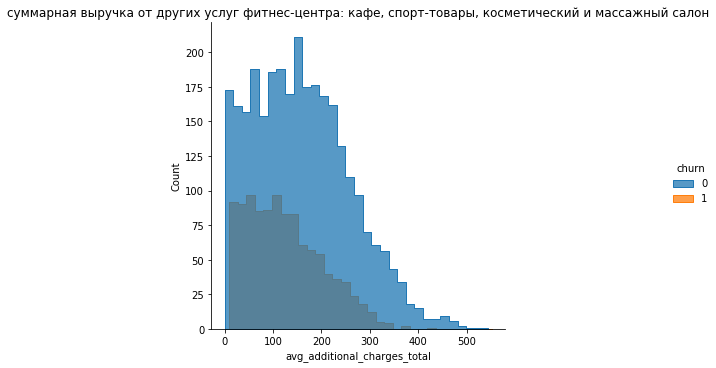

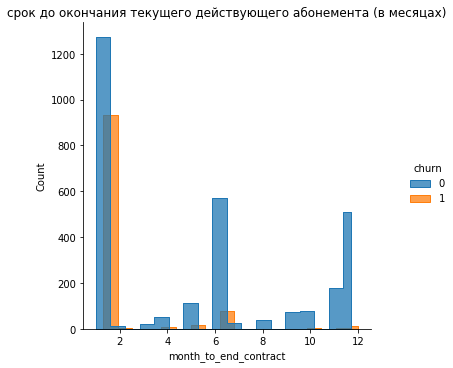

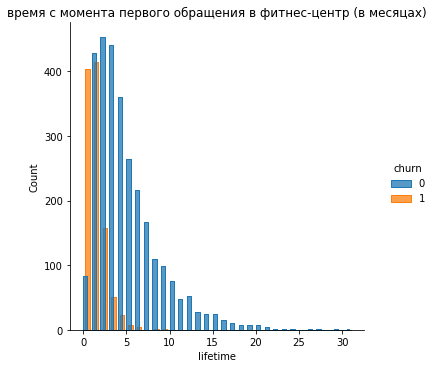

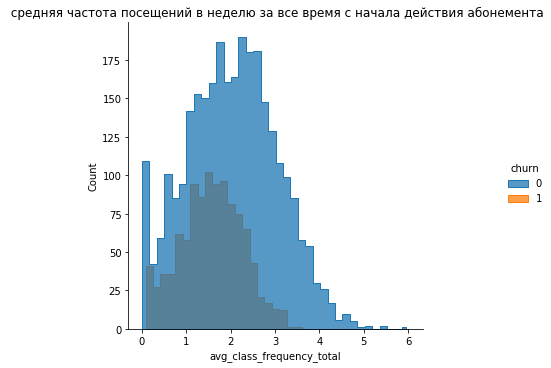

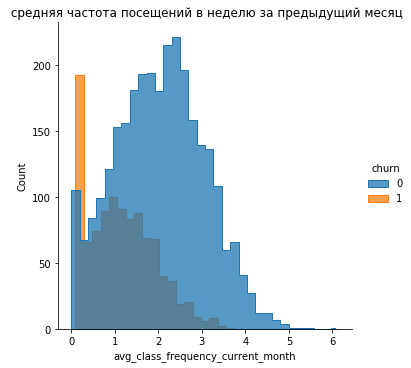

In [15]:
for col in df.drop('churn', axis = 1).columns:
    sns.displot(df, x=col, hue="churn", element="step", multiple="dodge")
    plt.title(titles[col]);

Из существенных различий между теми, кто ушел и теми, кто остался, выделим следующие.

- Среди тех, кто ушел в отток на 10% больше живущих или работающих вдалеке от фитнеса, и на 17% меньше тех, кто пришел по рекомендации друзей и также на 17% меньше сотрудников компании-партнера.

- Средний период абонемента тех, кто ушел в отток гораздо ниже - 1.73 против 5.75, ушедшие были в среднем записаны на фитнес не более 1 месяца , а оставшиеся - почти 5.

- Уходящие в среднем за текущий месяц посетили фитнес один раз за неделю, а остающиеся - два. Уходящие в полтора раза реже посещали групповые занятия в текущем месяце: только 27% из бросивших хоть раз их посетили.

- Они немного моложе, средний возраст: 27 против 30 лет.

То есть уходящие чаще территориально не имеют привязки к фитнесу, не пришли от друзей или компании-партнера, чаще записывались на короткий срок, как правило на месяц, реже пробовали групповые занятия, в целом реже посещали фитнесс, тратили немного меньше и возрастом были немного моложе.

#### Постройте матрицу корреляций и отобразите её.

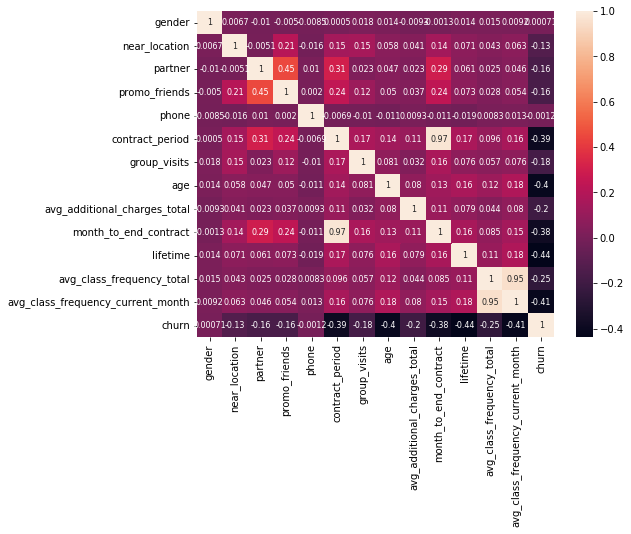

In [16]:
# построим и отрисуем матрицу корреляций
cm = df.corr() # вычисляем матрицу корреляций

# нарисуем тепловую карту для матрицы корреляций
plt.figure(figsize=(8,6))  
sns.heatmap(cm, annot = True, annot_kws = {'size':8});

На матрице корреляций видно, что  корреляция более 0.8 есть у признаков "длительность текущего действующего абонемента" и "срок до окончания текущего действующего абонемента" (корреляция 0.97), что вполне логично, так как эти величины взаимосвязаны.

Аналогичная ситуация  с признаком  "средняя частота посещений в неделю за все время с начала действия абонемента" и "средняя частота посещений в неделю за предыдущий месяц"(корреляция 0.95). Эти частоты довольно похожи.

Таким образом заметим, что модели, которые мы будем строить, должны учитывать мультиколлинеарность, иначе нам нужно будет удалить вручную один из двух признаком в каждом случае.

## Шаг 3. Постройте модель прогнозирования оттока клиентов

### Постройте модель бинарной классификации клиентов, где целевой признак — факт оттока клиента в следующем месяце:

#### Разбейте данные на обучающую и валидационную выборку функцией train_test_split().

In [17]:
# разделим наши данные на признаки (матрица X) и целевую переменную (y)
X = df.drop(columns=['churn'])
y = df['churn']

# разделяем модель на обучающую и валидационную выборку
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

#### Обучите модель на train-выборке двумя способами:
- логистической регрессией
- случайным лесом

In [18]:
# стандартизация данных перед работой с алгоритмами
sc = StandardScaler() # создадим объект класса StandardScaler 
X_train_st = sc.fit_transform(X_train) # обучаем scaler и одновременно трансформируем матрицу для обучающей выборки
X_test_st = sc.transform(X_test) # применяем стандартизацию к матрице признаков для тестовой выборки

*Модель логистичесой регрессии*

Хотя это необязательно для логистической регрессиии, проведем сначала стандартизацию.

*"It’s a good practice to standardize the input data that you use for logistic regression, although in many cases it’s not necessary. Standardization might improve the performance of your algorithm. It helps if you need to compare and interpret the weights. It’s important when you apply penalization because the algorithm is actually penalizing against the large values of the weights." https://realpython.com/logistic-regression-python/#logistic-regression-in-python

По поводу проблемы мультиколлинеарности заметим, что для логистической регрессии ‘liblinear’ solver по умолчанию осуществляет
регуляризацию L2, т.е. сильно коррелирующим признакам будут даны одинаковые веса. А для случайного леса эта проблема не релевантна.

In [19]:
# логистическая регрессия
model=LogisticRegression(solver='liblinear', random_state=0) 
model.fit(X_train_st, y_train)  # обучим модель
y_pred = model.predict(X_test_st) 
probabilities = model.predict_proba(X_test_st)[:,1]

Посмотрим на признаки с весами, согласно модели логистичесой регрессии.

In [20]:
titles_df = pd.DataFrame.from_dict(titles, orient='index').reset_index() 
# создадим датафрейм с названиями признаков на русском из словаря
titles_df.columns = ['feature','titles']    

In [21]:
coefficients = pd.concat([pd.DataFrame(X.columns), pd.DataFrame(np.transpose(model.coef_))], axis = 1)
coefficients.columns = ['feature', 'coeff']
coefficients.merge(titles_df, how='left', on='feature').sort_values(by='coeff', ascending=False)

,feature,coeff,titles
11,avg_class_frequency_total,3.29,средняя частота посещений в неделю за все вре...
4,phone,0.01,наличие контактного телефона
0,gender,-0.01,пол
1,near_location,-0.08,"проживание или работа в районе, где находится ..."
2,partner,-0.08,сотрудник компании-партнёра
3,promo_friends,-0.27,факт первоначальной записи в рамках акции «при...
6,group_visits,-0.39,факт посещения групповых занятий
9,month_to_end_contract,-0.52,срок до окончания текущего действующего абонем...
8,avg_additional_charges_total,-0.54,суммарная выручка от других услуг фитнес-центр...
5,contract_period,-0.70,длительность текущего действующего абонемента...


Наиболее важными признаками со знаком минус (то есть обратной зависимостью) оказались средняя частота посещений в неделю за предыдущий месяц, время с момента первого обращения в фитнес-центр, возраст и длительность текущего действующего абонемента. Чем они больше, тем выше вероятность, что клиент не попадет в отток, и наоборот.

Однако, средняя частота посещений в неделю за все время - также важный признак, но со знаком плюс, что контринтуитивно. Возможно, это объясняется тем, что в наших данных из тех, кто попал в отток 38% тех, кто пришел в тот месяц, по которому у нас данные (lifetime=0) и покинул фитнес после этого первого месяца. Данные по средней частоте посещений в неделю за предыдущий месяц и средняя частота посещений в неделю за все время с начала действия абонемента должны в таком случае совпадать. Но, это не так. Если взглянуть на срез (см.ниже), то видно, что есть случаи, где lifetime=0, при этом avg_class_frequency_total бoльше чем avg_class_frequency_current_month, что не вполне логично. Ведь раз время с момента первого обращения в фитнес-центр равно нулю, то весь период это и должен быть один месяц. Для дальнейшего прояснения этого вопроса, нам нужно знать, как считались эти метрики.

In [22]:
# отношения числа тех, кто пришел в месяц, по которому у нас даннные, и попал в отток, ко всем, кто попал в отток
len(df[(df['lifetime']==0) & (df['churn']==1)])/len(df[(df['churn']==1)]) 

0.37983034872761545

In [23]:
# те, кто пришел в тот месяц, по которому у нас даннные, и попал в отток 
df[(df['lifetime']==0) & (df['churn']==1)][['avg_class_frequency_total', 'avg_class_frequency_current_month']]

,avg_class_frequency_total,avg_class_frequency_current_month
7,1.21,1.05
25,1.49,1.25
46,0.85,0.00
57,1.00,0.00
70,1.72,1.34
...,...,...
3971,0.76,0.00
3976,1.31,1.06
3977,0.44,0.00
3982,1.39,0.79


*Случайный лес*

In [24]:
# случайный лес
model_rf = RandomForestClassifier(random_state=0, n_estimators=100) 
model_rf.fit(X_train_st, y_train)  # обучим модель
y_pred_rf = model_rf.predict(X_test_st) 
probabilities_rf = model_rf.predict_proba(X_test_st)[:,1]

Также посмотрим на важность признаков, согласно модели случайного леса.

In [25]:
model_rf.feature_importances_ 
# возвращает массив, в котором каждый индекс соответствует предполагаемой важности признака в обучающем наборе
coefficients_rf = pd.concat([pd.DataFrame(X.columns), pd.DataFrame(np.transpose(model_rf.feature_importances_))], axis = 1)
coefficients_rf.columns = ['feature', 'coeff']
coefficients_rf.merge(titles_df, how='left', on='feature').sort_values(by='coeff', ascending=False)

,feature,coeff,titles
10,lifetime,0.28,время с момента первого обращения в фитнес-цен...
12,avg_class_frequency_current_month,0.18,средняя частота посещений в неделю за предыду...
11,avg_class_frequency_total,0.13,средняя частота посещений в неделю за все вре...
7,age,0.12,возраст
8,avg_additional_charges_total,0.09,суммарная выручка от других услуг фитнес-центр...
9,month_to_end_contract,0.07,срок до окончания текущего действующего абонем...
5,contract_period,0.07,длительность текущего действующего абонемента...
6,group_visits,0.02,факт посещения групповых занятий
0,gender,0.01,пол
2,partner,0.01,сотрудник компании-партнёра


Для модели случайного леса, наиболее важными признаком оказались время с момента первого обращения в фитнес-центр, затем средняя частота посещений в неделю за предыдущий месяц, средняя частота посещений в неделю за все время и возраст.

#### Оцените метрики accuracy, precision и recall для обеих моделей на валидационной выборке. Сравните по ним модели. Какая модель показала себя лучше на основании метрик?

In [26]:
print('Логистическая регрессия')
print('Accuracy: {:.2f}'.format(accuracy_score(y_test, y_pred))) # Доля правильных ответов
print('Precision: {:.2f}'.format(precision_score(y_test, y_pred)))
print('Recall: {:.2f}'.format(recall_score(y_test, y_pred)))
print('F1: {:.2f}'.format(f1_score(y_test, y_pred)))
print('ROC_AUC: {:.2f}'.format(roc_auc_score(y_test, probabilities)))

Логистическая регрессия
Accuracy: 0.92
Precision: 0.85
Recall: 0.83
F1: 0.84
ROC_AUC: 0.97


In [27]:
print('Случайный лес')
print('Accuracy: {:.2f}'.format(accuracy_score(y_test, y_pred_rf))) # Доля правильных ответов
print('Precision: {:.2f}'.format(precision_score(y_test, y_pred_rf)))
print('Recall: {:.2f}'.format(recall_score(y_test, y_pred_rf)))
print('F1: {:.2f}'.format(f1_score(y_test, y_pred_rf)))
print('ROC_AUC: {:.2f}'.format(roc_auc_score(y_test, probabilities_rf)))

Случайный лес
Accuracy: 0.92
Precision: 0.84
Recall: 0.81
F1: 0.83
ROC_AUC: 0.97


Accuracy - доля правильных ответов у обеих моделей 0.92, однако заметим, что в нашем случае не соблюдалось условие баланса классов — когда объектов каждого класса примерно поровну,  а значит не стоит ориентироваться на данную метрику.

precision - т.е. какая доля прогнозов относительно "1" класса верна у логистической регрессии 0.85, на 1% больше чем у Случайного леса. Здесь мы смотрим на долю правильных ответов только среди целевого класса. Нам особенно важна эта метрика, если каждое срабатывание модели — факт отнесения к классу "1" — стоит ресурсов, т.е. если мы будем тратить деньги на каждого, кого подскажем клиента, которые попадет в отток (например, подарив существенную скидку на месяц абонемента). Если же мы будем рассылать письма с полезной информацией о новых занятиях, например, то послать их большему числу людей ничего не стоит.

recall показывает, сколько реальных объектов "1" класса мы смогли обнаружить с помощью модели. У нашей логистической регрессии recall составляет 0.83, на 2% больше чем у Случайного леса. В нашем случае эта метрика важна. Лучше обнаружить максимум тех, кто перестанет пользоваться фитнесом, а лишнее срабатывание скорее всего не будет стоить больших ресурсов.

Так как precision и recall направлены на избежание противоположных рисков, посмотрим метрику, учитывающую баланс между метриками. Это F1-score:  у логистической регрессии он снова на 1% выше: 0.84.


Посмотрим также oc_auc, или площадь под кривой ошибок — AUC-ROC. У обеих моделей она одинакова: 0.97. Эта метрика подходит для несбалансированных классов и показывает, насколько хорошо будут выделяться реальные классы объектов, если отсортировать объекты по вероятности, которую спрогнозировала модель.

Мы можем сказать, что обе модели ведут себя очень адекватно, но логистическая регрессия немного лучше по Precision и
Recall.

## Шаг 4. Сделайте кластеризацию клиентов

Отложите в сторону столбец с оттоком и проведите кластеризацию объектов (клиентов):
- Стандартизируйте данные.

In [28]:
# стандартизация данных перед работой с алгоритмами
X_sc = sc.fit_transform(X)

- Постройте матрицу расстояний функцией linkage() на стандартизованной матрице признаков и нарисуйте дендрограмму. Внимание: отрисовка дендрограммы может занять время! На основании полученного графика предположите, какое количество кластеров можно выделить.

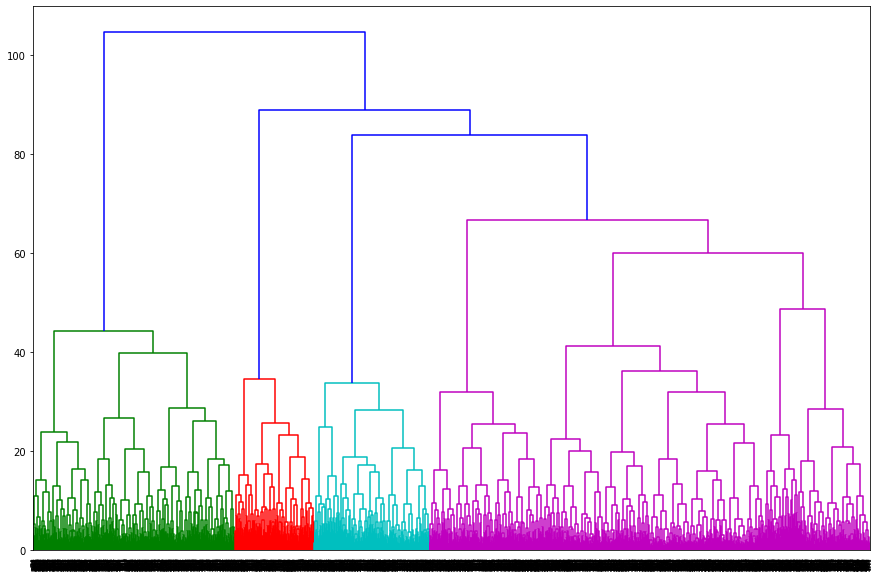

In [29]:
linked = linkage(X_sc, method = 'ward')
plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top')
plt.show()

На основании полученного графика мы можем выделить четыре кластера, поэтому кластеризацию на основании алгоритма K-Means мы будем осуществлять именно для 4-х кластеров.

- Обучите модель кластеризации на основании алгоритма K-Means и спрогнозируйте кластеры клиентов. Договоримся за число кластеров принять n=5, чтобы ваши результаты можно было сравнивать с результатами остальных студентов. Однако, конечно, в жизни никто не скажет вам правильный ответ, и решение остаётся за вами (на основании изучения графика из предыдущего пункта).

In [30]:
# зададим модель k_means с количеством кластеров 4
km = KMeans(n_clusters = 4, random_state=1)
# спрогнозируем кластеры для наблюдений (алгоритм присваивает им номера от 0 до 2)
labels = km.fit_predict(X_sc)

# сохраним метки кластера в поле нашего датасета
df['cluster'] = labels

# посчитаем метрику силуэта для нашей кластеризации
print('Silhouette_score: {:.2f}'.format(silhouette_score(X_sc, labels)))

Silhouette_score: 0.13


Заметим, что значение метрики силуэта принимает значения от -1 до 1. Чем ближе к 1, тем качественнее кластеризация. В нашем случае она 0.13, что нельзя назвать высококачественной кластеризацией.

- Посмотрите на средние значения признаков для кластеров. Можно ли сразу что-то заметить?


In [31]:
df_features_cluster = df.groupby('cluster')[df.drop('cluster', axis = 1).columns].agg(
    ['mean']).sort_values(by=('churn', 'mean'))

In [32]:
with pd.option_context('display.precision', 2):
    df_features_cluster=df_features_cluster.style.background_gradient(cmap = 'Blues')
df_features_cluster

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean
cluster,,,,,,,,,,,,,,
2,0.51,0.96,0.78,0.57,0.89,11,0.55,30,1.6e+02,10,4.7,2,2,0.028
0,0.56,0.98,0.35,0.25,0.91,2.7,0.47,30,1.6e+02,2.5,5,2.8,2.8,0.072
3,0.5,0,0.46,0.076,0.92,2.3,0.22,29,1.3e+02,2.2,2.8,1.7,1.5,0.44
1,0.48,1,0.35,0.23,0.9,2,0.34,28,1.3e+02,1.9,2.4,1.2,1,0.52


Мы видим, что в двух кластерах из четырех средние по оттоку гораздо выше, а именно около 0.5, т.е. половина кластера это ушедшие. т.е. эта характеристика распределилась не равным образом по всем кластерам, а присуща только двум из них. 
Таким образом у нас есть потенциально два кластера для более целевой работы по оттоку. Посмотрим на их характеристики.
Также, например, видно, что все кто живут далеко попали в один кластер, те, у кого годовой абонемент тоже попали в один кластер.

- Постройте распределения признаков для кластеров. Можно ли что-то заметить по ним?

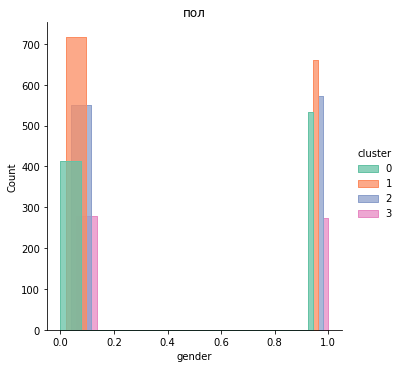

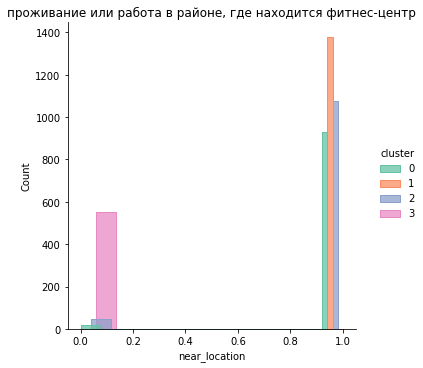

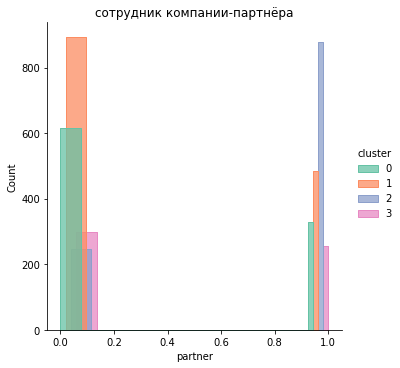

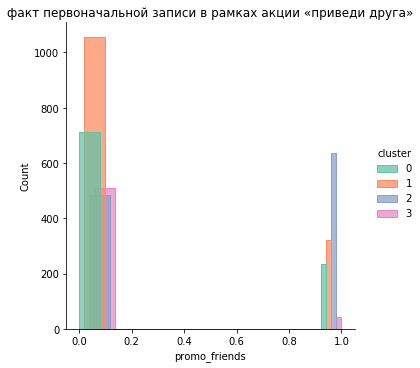

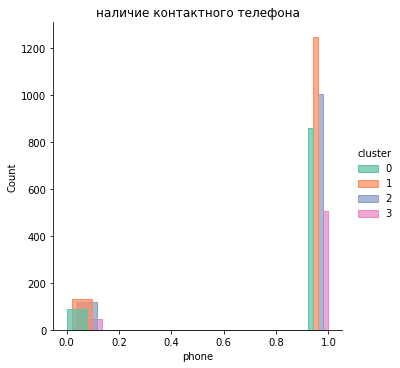

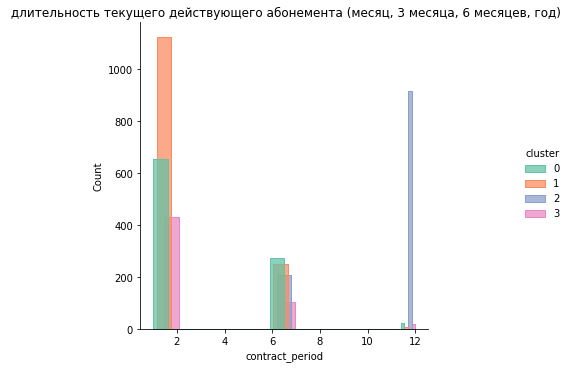

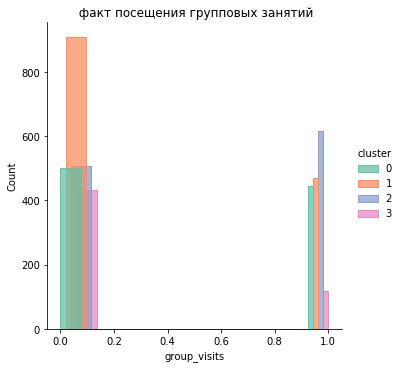

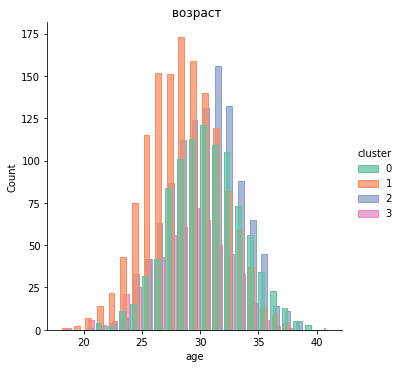

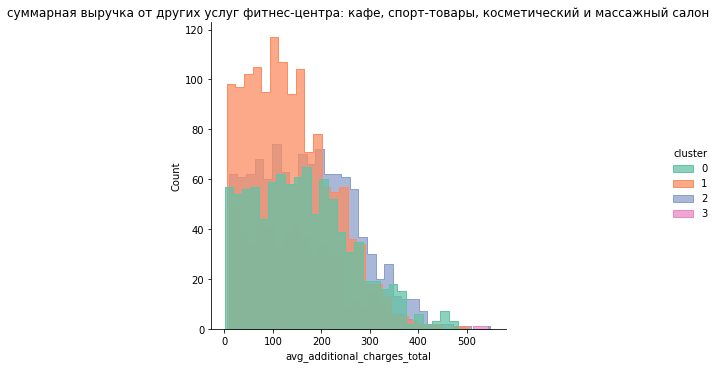

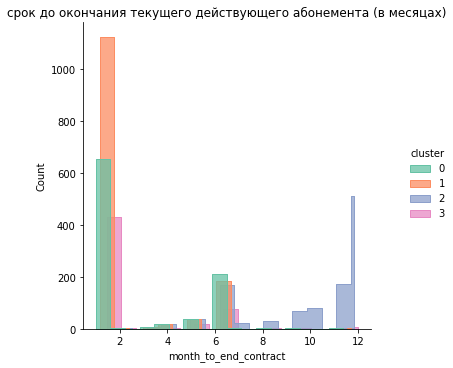

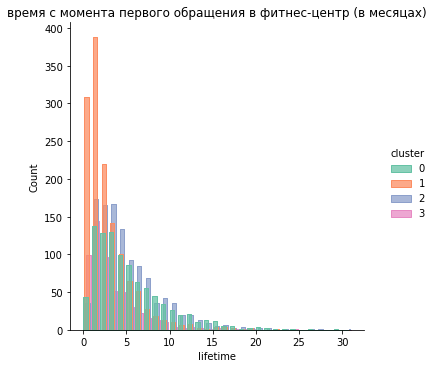

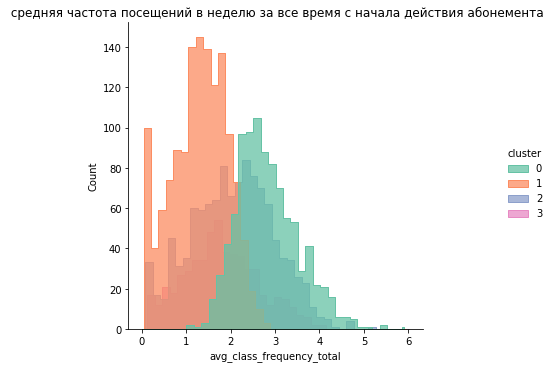

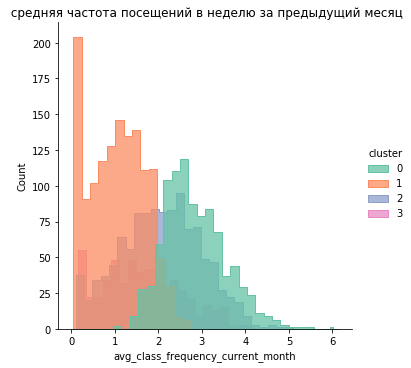

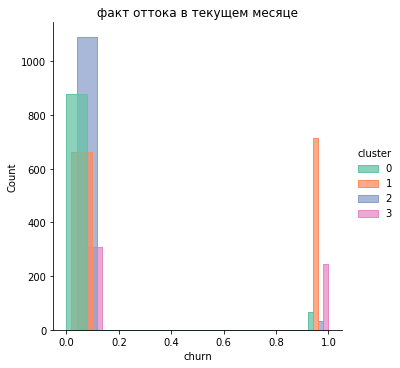

In [33]:
for col in df.drop('cluster', axis = 1).columns:
    sns.displot(df, x= col, hue="cluster", element="step", multiple="dodge", palette='Set2').set(title=titles[col]); 

Для одного из "отточных" кластеров очень характерно, что его участники не живут или работают рядом с фитнесом. Для другого, что в большинстве они не работники партнера и не пришли по акции от друзей. 

Также обоих "отточных" кластеров в подавляющем большинстве абонементы на месяц, сроки до окончания абонемента у них короче и туда попали те, кто записался недавно (их lifetime, время с момента первого обращения в фитнес-центр меньше)
Также там меньше доля тех, кто пробовал групповые занятия, они реже посещают фитнес и немного моложе.

- Для каждого полученного кластера посчитайте долю оттока (методом groupby()). Отличаются ли они по доле оттока? Какие кластеры склонны к оттоку, а какие — надёжны?

In [34]:
df_churn_rate = df.groupby('cluster')['churn'].agg(['mean'])
df_churn_rate

,mean
cluster,
0,0.07
1,0.52
2,0.03
3,0.44


Как мы заметили, у нас есть два класса, сконных к оттоку (номер 1 и 3) и чьи характеристи мы описали выше.

## Шаг 5. Сформулируйте выводы и сделайте базовые рекомендации по работе с клиентами

Сформулируйте основные выводы и предложите рекомендации для стратегии взаимодействия с клиентами и их удержания.
Не описывайте стратегию детально: достаточно 3-4 важных принципов и примеров их реализации в виде определённых маркетинговых действий.

#### Выводы

- В нашем датасете информация о 4000 пользователей и 14 признаках по каждому. Тех, кто ушел примерно четверть.
- Уходящие чаще территориально не имеют привязки к фитнесу, не пришли от друзей или компании-партнёра.
- Те, кто ушел в отток гораздо чаще записывались на короткий срок, как правило на один месяц.
- Уходящие реже посещали фитнесс, и реже пробовали групповые занятия
- Те, кто ушел в отток тратили немного меньше и возрастом были немного моложе
- Мы выбрали модель логистической регрессии для предсказания оттока
- Мы выделили четыре кластера посетителей фитнеса, два из которых склонных к оттоку.
- Мы охарактеризовали 2 кластера, как склонные к оттоку:
    - туда попали те, кто не живут или работают рядом с фитнесом
    - те кто пришел "со стороны" (не от друзей или от работы партнера центра)
    - те, у кого абонементы на месяц, и короткие сроки до окончания абонемента
    - те, кто записался недавно
    - те, кто редко посещают фитнес
    - те, кто не пробовал групповые занятия

#### Стратегия

Благодаря предсказанию оттока, мы можем взаимодействовать с клиентами, попавшими в группу прогнозируемого оттока на каждый месяц. Особенно необходимо отмечать тех, у кого скоро заканчивается абонемент.
Это могут быть скидка на абонемент на следующий месяц, или же скидка на абонемент при записи на 3, 6 или 12 месяцев - чем дольше период, тем больше скидка. Для нас важно, чтобы клиент оставался записан дольше, это снижает вероятность попадания в отток. Люди, записанные на год, как мы обнаружили, реже бросают. Т.е. в зависимости от средств мы будем предлагать персонализированные скидки на абонемент тем, кто попал в группу прогнозируемого оттока.

Также мы можем мотивировать посещение центра этими клиентами, и посещение ими групповых занятий. Повышение частоты занятий является важным фактором против оттока. Мы можем подарить им занятие с личным тренером в малой группе или индивидуально (в зависимости от ресурсов), это стимулирует частоту. Мы можем активнее рекламировать групповые занятия и сделать их более привлекательными, с более удобным расписанием.

Что касается работы с полученными кластерами - здесь мы использовать полученные "отточные группы" и отправлять рассылки, в соответствии с выделенными характеристиками. Например, для тех, кто пришел "со стороны" возможность подарить скидку другу и получить что-то самому (скидку на следующий месяц, бесплатное индивидуальное занятие, мерч). Это привлечет новых клиентов и удержит старых т.к. эти клиенты будут иметь в фитнес-центре знакомых, с кем вместе ходить, что в свою очередь повышает посещаемость. Также в этих кластерах можно поработать над посещаемостью через рассылки с анонсами групповых занятий или персональными отчетами статистики посещений.